# Particle Tagging

### Get the dataset

In [1]:
download = True
develop = True

if download:
    !rm -rf InputFiles/*
    if develop:
        !wget http://www.stanford.edu/~kterao/public_data/v0.1.0/2d/classification/five_particles/practice_train_5k.root -O InputFiles/classification_train.root
        !wget http://www.stanford.edu/~kterao/public_data/v0.1.0/2d/classification/five_particles/practice_test_5k.root -O InputFiles/classification_test.root
        !wget http://www.stanford.edu/~kterao/public_data/v0.1.0/2d/segmentation/multipvtx/practice_train_2k.root -O InputFiles/segmentation_train.root
        #!wget http://www.stanford.edu/~kterao/public_data/v0.1.0/2d/segmentation/multipvtx/practice_test_2k.root -O InputFiles/segmentation_test.root
    else:
        !wget http://www.stanford.edu/~kterao/public_data/v0.1.0/2d/classification/five_particles/train_50k.root -O InputFiles/classification_train.root
        !wget http://www.stanford.edu/~kterao/public_data/v0.1.0/2d/classification/five_particles/test_40k.root -O InputFiles/classification_test.root
        !wget http://www.stanford.edu/~kterao/public_data/v0.1.0/2d/segmentation/multipvtx/train_15k.root -O InputFiles/segmentation_train.root
        #!wget http://www.stanford.edu/~kterao/public_data/v0.1.0/2d/segmentation/multipvtx/test_10k.root -O InputFiles/segmentation_test.root

## Classification

In [2]:
import ROOT
from larcv import larcv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PlottingTools as pt
%matplotlib inline 

from tqdm import tqdm
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True          

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3 
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.optimizers import SGD

from keras import backend as K
print '\nData format for Keras is:', K.image_data_format()

!rm -rf Plots/*

Welcome to JupyROOT 6.12/04


ImportError: No module named larcv

In [ ]:
# Common variables for all models
epochs = 200
batchSize = 25

imageLength = 256
imageHeight = 256

# Stop training when a monitored quantity has stopped improving after 20 epochs
earlyStop = EarlyStopping(patience=20, verbose=1)

# Reduce learning rate when a metric has stopped improving
reduceLR = ReduceLROnPlateau(factor=0.3, patience=3, cooldown=3, verbose=1)

pdgToCategory =  {11   : 0, #electron
                  22   : 1, #gamma
                  13   : 2, #muon
                  211  : 3, #pion
                  2212 : 4} #proton

pdgToParticle =  {11   : 'Electron',
                  22   : 'Gamma',
                  13   : 'Muon',
                  211  : 'Pion',
                  2212 : 'Proton'}

location = [0, 1, 2, 3, 4]
labels = ['electron', 'gamma', 'muon', 'pion', 'proton']

### Load the training and test datasets

In [ ]:
train_image_chain = ROOT.TChain("image2d_data_tree")
train_image_chain.AddFile('InputFiles/classification_train.root')
print 'Found', train_image_chain.GetEntries(), 'images in training dataset!'

test_image_chain = ROOT.TChain("image2d_data_tree")
test_image_chain.AddFile('InputFiles/classification_test.root')
print 'Found', test_image_chain.GetEntries(), 'images in test dataset!'

train_label_chain = ROOT.TChain("particle_mctruth_tree")
train_label_chain.AddFile('InputFiles/classification_train.root')
print 'Found', train_label_chain.GetEntries(), 'labels in training dataset!'

test_label_chain = ROOT.TChain("particle_mctruth_tree")
test_label_chain.AddFile('InputFiles/classification_test.root')
print 'Found', test_label_chain.GetEntries(), 'labels in test dataset!'

### Visualize training images in detail

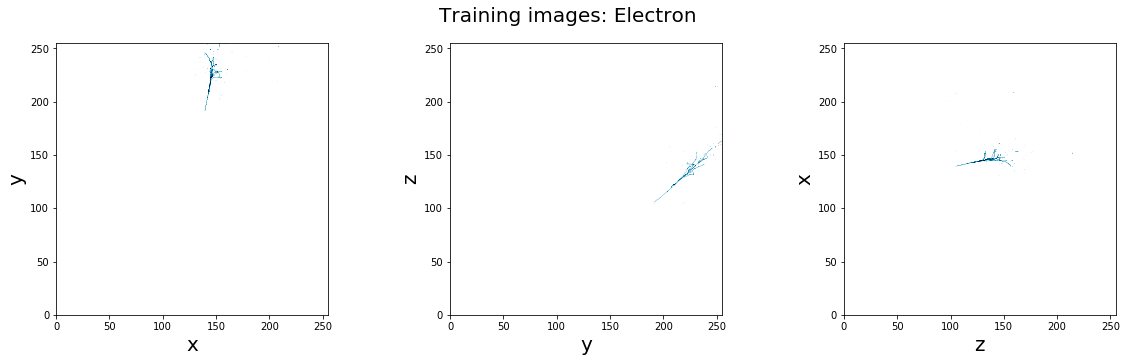

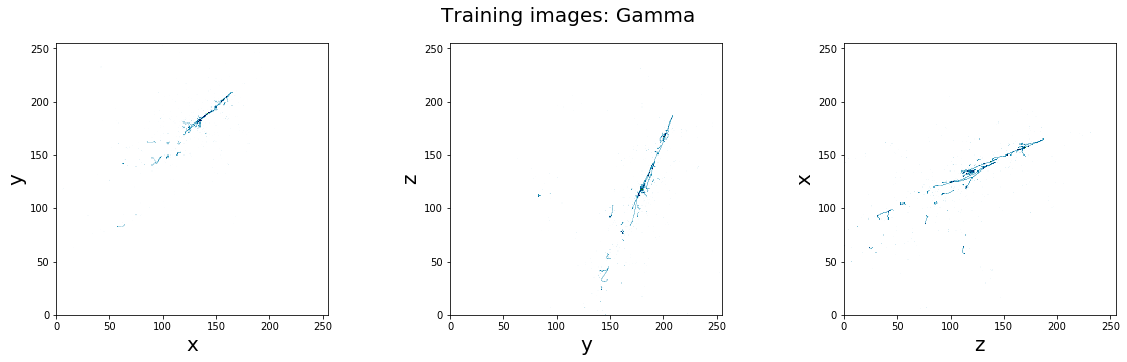

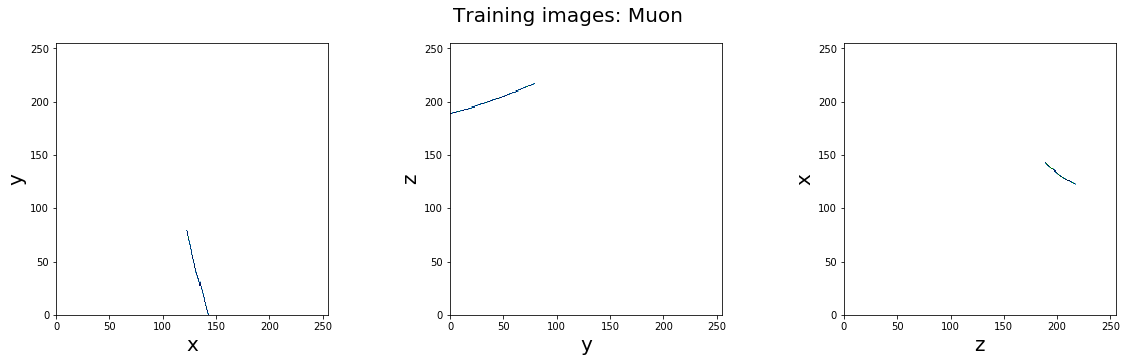

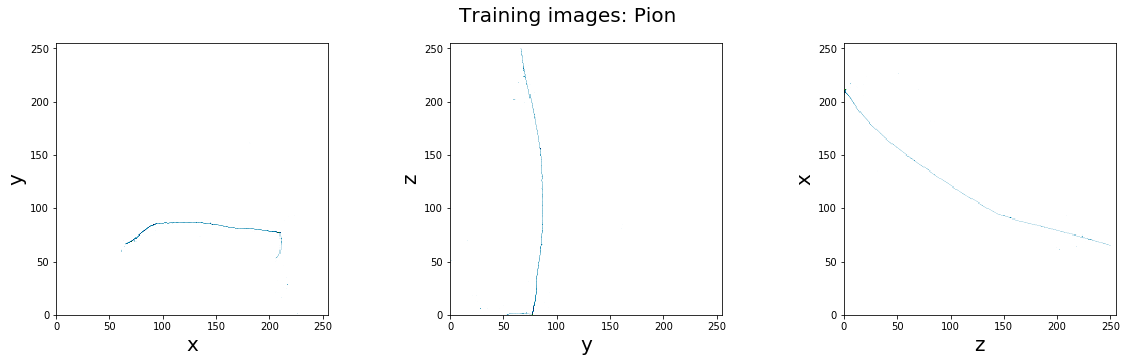

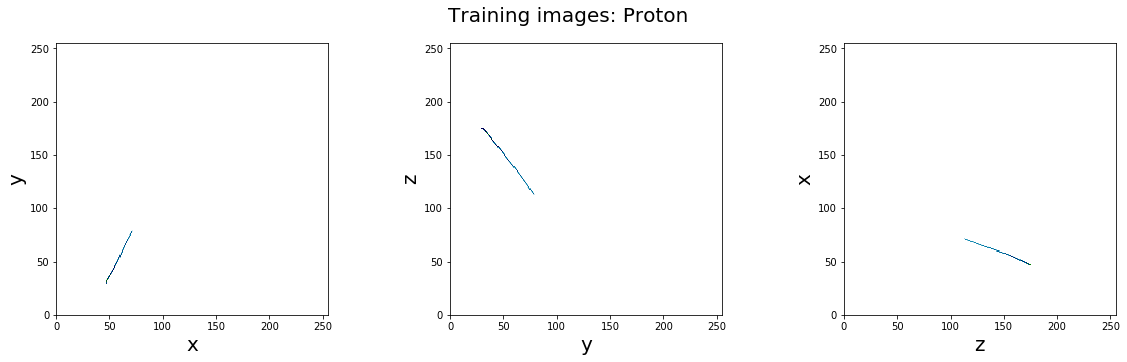

In [5]:
def get_view_range(image2d):
    nz_pixels=np.where(image2d>=0.0)
    ylim = (np.min(nz_pixels[0])-5,np.max(nz_pixels[0])+5)
    xlim = (np.min(nz_pixels[1])-5,np.max(nz_pixels[1])+5)
    # Adjust for allowed image range
    ylim = (np.max((ylim[0],0)), np.min((ylim[1],image2d.shape[1]-1)))
    xlim = (np.max((xlim[0],0)), np.min((xlim[1],image2d.shape[0]-1)))
    return (xlim,ylim)
xAxis=['x', 'y', 'z']
yAxis=['y', 'z', 'x']

entryList = [x*1000 for x in range(5)]
for entry in entryList:
    train_image_chain.GetEntry(entry)
    image_object = train_image_chain.image2d_data_branch
    image_vector = image_object.as_vector()

    fig = plt.figure(figsize=(20,5))
    for index, image in enumerate(image_vector):
        ax = fig.add_subplot(1, 3, index+1)
        numpyImage = larcv.as_ndarray(image)
        ax.imshow(numpyImage, interpolation='none',cmap='ocean_r', origin='lower')
        
        ax.set_xlabel(xAxis[index], fontsize=20)
        ax.set_ylabel(yAxis[index], fontsize=20)
        
        xlim, ylim = get_view_range(numpyImage)
        
        # Set range
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)

    train_label_chain.GetEntry(entry)
    label_object = train_label_chain.particle_mctruth_branch
    for particle in label_object.as_vector():
        fig.suptitle('Training images: {}'.format(pdgToParticle[particle.pdg_code()]), fontsize=20)
        plt.show()
        fig.savefig('Plots/ClassificationTrainingImage{}.pdf'.format(pdgToParticle[particle.pdg_code()]), bbox_inches='tight')

### Tools to preprocess the images and labels for Keras

In [6]:
def imageToTensor(imageToConvert):
    # imageToConvert is a C++ class larcv::EventImage2D exposed to python interpreter
    # Note here that std::vectors in pyroot are iterable
    array2D = imageToConvert.as_vector()

    array3D = []
    for _, image in enumerate(array2D):
        # larcv has a helper function to convert std::vector to numpy array, so we can use that:
        numpyImage = larcv.as_ndarray(image)
        array3D.append(numpyImage)        
    tensor3D = np.stack((array3D[0], array3D[1], array3D[2]), -1)

    # Convert 3D tensor to 4D tensor with shape (1, imageLength, imageHeight, 3) and return 4D tensor
    return tensor3D

def imageChainToTensor(imageChain):
    listOfTensors = []
    for entry in tqdm(xrange(imageChain.GetEntries())):
        imageChain.GetEntry(entry)
        entryData = imageChain.image2d_data_branch
        listOfTensors.append(imageToTensor(entryData))
    return np.array(listOfTensors)

def labelChainToArray(labelChain):
    listOfLabels = []
    for entry in tqdm(xrange(labelChain.GetEntries())):
        labelChain.GetEntry(entry)
        particle = labelChain.particle_mctruth_branch.as_vector().front()
        listOfLabels.append(pdgToCategory[particle.pdg_code()])
    return np.array(listOfLabels)

In [7]:
# Convert every images to 4D tensors
X_train = imageChainToTensor(train_image_chain)
X_test = imageChainToTensor(test_image_chain)

print X_train.shape
print X_test.shape

100%|██████████| 5000/5000 [00:07<00:00, 644.95it/s]


(5000, 256, 256, 3)
(5000, 256, 256, 3)


In [8]:
print X_train[0].shape

(256, 256, 3)


### Split data into training and validation (80/20)

In [9]:
# There are 5 different particle types in the dataset
num_classes = 5
trainLabelArray = labelChainToArray(train_label_chain)
testLabelArray = labelChainToArray(test_label_chain)

y_train = np_utils.to_categorical(trainLabelArray, num_classes)
y_test = np_utils.to_categorical(testLabelArray, num_classes)
print y_train[:10]

100%|██████████| 5000/5000 [00:00<00:00, 42814.05it/s]

[[ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]]


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=99)
print("The training set has %d samples." % len(X_train))
print("The validation set has %d samples." % len(X_val))
print("The test set has %d samples." % len(X_test))

The training set has 4000 samples.
The validation set has 1000 samples.
The test set has 5000 samples.


## Benchmark model

In [1]:
benchmarkModel = Sequential()

benchmarkModel.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu',
                          input_shape=X_train[0].shape))
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.65))

benchmarkModel.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.65))

benchmarkModel.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.65))

benchmarkModel.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
benchmarkModel.add(MaxPooling2D(pool_size=2))
benchmarkModel.add(Dropout(0.65))

benchmarkModel.add(Flatten())         
benchmarkModel.add(Dense(500, activation='relu'))
benchmarkModel.add(Dropout(0.5))

benchmarkModel.add(Dense(num_classes, activation='softmax'))

benchmarkModel.summary()

NameError: name 'Sequential' is not defined

### Compile the code

In [12]:
benchmarkModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Calculate the classification accuracy of the benchmark model (before training)

In [13]:
# Evaluate the test accuracy
score = benchmarkModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the benchmark model (before training): %.4f%%' % accuracy)

Test accuracy of the benchmark model (before training): 20.6600%


2018-05-01 00:31:36.663538: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-05-01 00:31:36.663569: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-05-01 00:31:36.663575: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2018-05-01 00:31:36.663580: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2018-05-01 00:31:36.663584: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't

### Train the model

Epoch 00000: val_loss improved from inf to 2.06519, saving model to SavedModels/ClassificationBenchmarkBest.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve

Epoch 00004: reducing learning rate to 0.000300000014249.
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve

Epoch 00010: reducing learning rate to 9.00000042748e-05.
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve

Epoch 00016: reducing learning rate to 2.70000004093e-05.
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss did not improve
Epoch 00019: val_loss did 

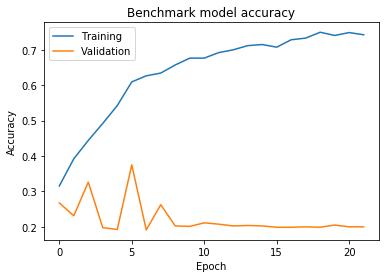

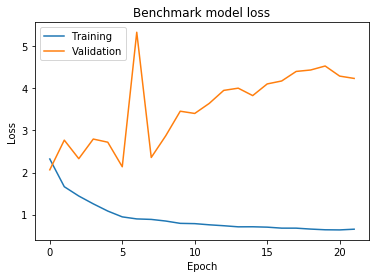

In [14]:
# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/ClassificationBenchmarkBest.hdf5', 
                               verbose=1, save_best_only=True)
history = benchmarkModel.fit(X_train, y_train, batch_size=batchSize, epochs=epochs,
                             validation_split=0.20, callbacks=[checkPoint, earlyStop, reduceLR],
                             verbose=0, shuffle=True)

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Benchmark model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/ClassificationBenchmarkAccuracy.pdf', bbox_inches='tight')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Benchmark model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/ClassificationBenchmarkLoss.pdf', bbox_inches='tight')
plt.show()

### Calculate the classification accuracy of the model (after training)

In [15]:
# Load the model with the best classification accuracy on the validation set
benchmarkModel.load_weights('SavedModels/ClassificationBenchmarkBest.hdf5')

# Calculate the classification accuracy on the test set
score = benchmarkModel.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the benchmark model (after training): %.4f%%' % accuracy)

Test accuracy of the benchmark model (after training): 25.5600%


### Visualize the result of the model

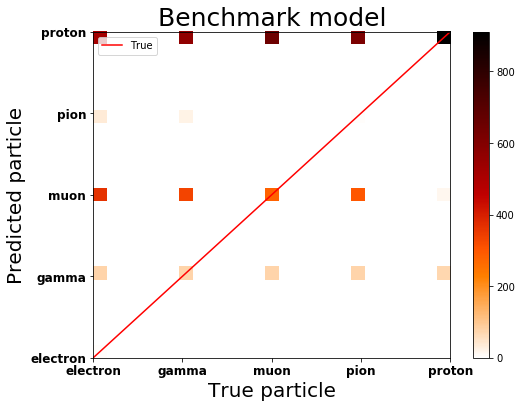

In [16]:
y_pred = benchmarkModel.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (8,6))
counts, xedges, yedges, im = ax1.hist2d(y_t, y_p, bins=(25, 25), cmap='gist_heat_r')
plt.colorbar(im, ax=ax1)
ax1.plot(y_t, y_t, 'r-', label = 'True')
plt.xticks(location, labels)
plt.yticks(location, labels)

ax1.legend()
ax1.set_title('Benchmark model', fontsize=25)
ax1.set_xlabel('True particle', fontsize=20)
ax1.set_ylabel('Predicted particle', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/ClassificationBenchmarkResult.pdf', bbox_inches='tight')

## Model based on InceptionV3

In [17]:
# Load InceptionV3 model + remove final classification layers
baseModel = InceptionV3(weights='imagenet', include_top=False, input_shape=(imageLength, imageHeight, 3))

# Add a global average pooling layer
myLayers = baseModel.output
myLayers = GlobalAveragePooling2D()(myLayers)
myLayers = Dropout(0.5)(myLayers)

# A fully connected layer
myLayers = Dense(1000, activation='relu')(myLayers)
myLayers = Dropout(0.5)(myLayers)

# Output layer
predictions = Dense(num_classes, activation='softmax')(myLayers)

# The model
InceptionV3Model = Model(inputs=baseModel.input, outputs=predictions)

# Freeze all convolutional InceptionV3 layers
for layer in baseModel.layers:
    layer.trainable = False
    
#InceptionV3Model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, 127, 127, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_6 (BatchNorm (None, 127, 127, 32)  96          conv2d_5[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 127, 127, 32)  0           batch_normalization_6[0][0]      
___________________________________________________________________________________________

### Compile the code

In [18]:
InceptionV3Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the model

Epoch 00000: val_loss improved from inf to 1.03901, saving model to SavedModels/ClassificationInceptionV3BottleneckBest.hdf5
Epoch 00001: val_loss improved from 1.03901 to 0.92687, saving model to SavedModels/ClassificationInceptionV3BottleneckBest.hdf5
Epoch 00002: val_loss improved from 0.92687 to 0.88836, saving model to SavedModels/ClassificationInceptionV3BottleneckBest.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.88836 to 0.87017, saving model to SavedModels/ClassificationInceptionV3BottleneckBest.hdf5
Epoch 00005: val_loss improved from 0.87017 to 0.86691, saving model to SavedModels/ClassificationInceptionV3BottleneckBest.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.86691 to 0.83252, saving model to SavedModels/ClassificationInceptionV3BottleneckBest.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss improved from 0.83

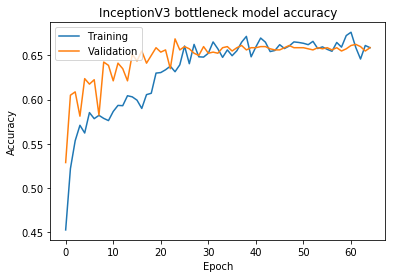

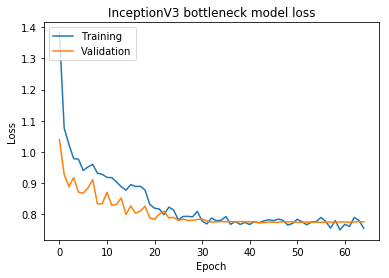

In [19]:
# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/ClassificationInceptionV3BottleneckBest.hdf5', 
                               verbose=1, save_best_only=True)
history = InceptionV3Model.fit(X_train, y_train, batch_size=batchSize, epochs=epochs,
                               validation_split=0.20, callbacks=[checkPoint, earlyStop, reduceLR],
                               verbose=0, shuffle=True)

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('InceptionV3 bottleneck model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/ClassificationInceptionV3BottleneckAccuracy.pdf', bbox_inches='tight')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 bottleneck model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/ClassificationInceptionV3BottleneckLoss.pdf', bbox_inches='tight')
plt.show()

### Calculate the classification accuracy of the model (after training)

In [20]:
# Load the model with the best classification accuracy on the validation set
InceptionV3Model.load_weights('SavedModels/ClassificationInceptionV3BottleneckBest.hdf5')

# Calculate the classification accuracy on the test set
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (after training): %.4f%%' % accuracy)

Test accuracy of the model (after training): 65.4400%


### Visualize the result of the model

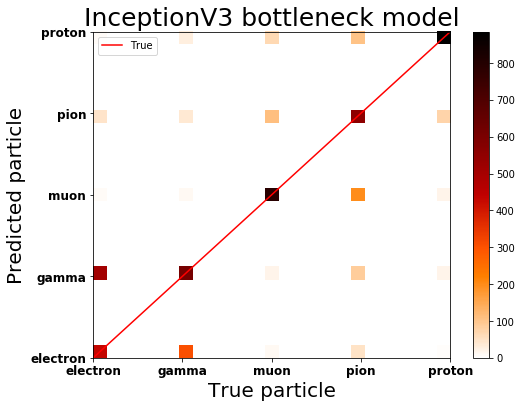

In [21]:
y_pred = InceptionV3Model.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (8,6))
counts, xedges, yedges, im = ax1.hist2d(y_t, y_p, bins=(25, 25), cmap='gist_heat_r')
plt.colorbar(im, ax=ax1)
ax1.plot(y_t, y_t, 'r-', label = 'True')
plt.xticks(location, labels)
plt.yticks(location, labels)

ax1.legend()
ax1.set_title('InceptionV3 bottleneck model', fontsize=25)
ax1.set_xlabel('True particle', fontsize=20)
ax1.set_ylabel('Predicted particle', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/ClassificationInceptionV3BottleneckResult.pdf', bbox_inches='tight')

### Visualize layer names and layer indices to see how many layers to freeze (to fine-tune the model)

In [22]:
#for i, layer in enumerate(baseModel.layers):
   #print i, layer.name

0 input_1
1 conv2d_5
2 batch_normalization_6
3 activation_1
4 conv2d_6
5 batch_normalization_7
6 activation_2
7 conv2d_7
8 batch_normalization_8
9 activation_3
10 max_pooling2d_5
11 conv2d_8
12 batch_normalization_9
13 activation_4
14 conv2d_9
15 batch_normalization_10
16 activation_5
17 max_pooling2d_6
18 conv2d_13
19 batch_normalization_14
20 activation_9
21 conv2d_11
22 conv2d_14
23 batch_normalization_12
24 batch_normalization_15
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_10
29 conv2d_12
30 conv2d_15
31 conv2d_16
32 batch_normalization_11
33 batch_normalization_13
34 batch_normalization_16
35 batch_normalization_17
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_20
42 batch_normalization_21
43 activation_16
44 conv2d_18
45 conv2d_21
46 batch_normalization_19
47 batch_normalization_22
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_17
52 conv2d_19
53 conv2d_22
54 conv2d_23
55 batch_normalization_18
56 ba

### Train the top few inception blocks

In [23]:
# Let's train the top 3 inception blocks
# Freeze the first 229 layers
for layer in InceptionV3Model.layers[:229]:
   layer.trainable = False
for layer in InceptionV3Model.layers[229:]:
   layer.trainable = True

### Compile the code

In [24]:
InceptionV3Model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.005, momentum=0.9), metrics=['accuracy'])

### Train the model

Epoch 00000: val_loss improved from inf to 0.81233, saving model to SavedModels/ClassificationInceptionV3FineTunedBest.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve

Epoch 00004: reducing learning rate to 0.00149999996647.
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve

Epoch 00010: reducing learning rate to 0.000450000003912.
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss did not improve
Epoch 00015: val_loss did not improve
Epoch 00016: val_loss did not improve

Epoch 00016: reducing learning rate to 0.000134999997681.
Epoch 00017: val_loss did not improve
Epoch 00018: val_loss did not improve
Epoch 00019: val

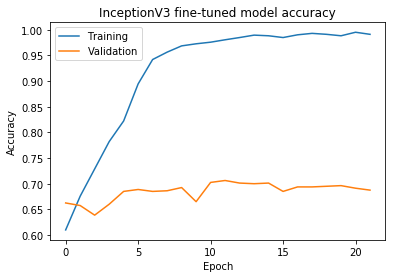

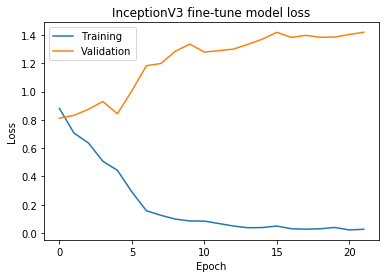

In [25]:
# Save the best model after every epoch
checkPoint = ModelCheckpoint(filepath='SavedModels/ClassificationInceptionV3FineTunedBest.hdf5', 
                               verbose=1, save_best_only=True)

history = InceptionV3Model.fit(X_train, y_train, batch_size=batchSize, epochs=epochs,
                               validation_split=0.20, callbacks=[checkPoint, earlyStop, reduceLR],
                               verbose=0, shuffle=True)

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('InceptionV3 fine-tuned model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/ClassificationInceptionV3FineTunedAccuracy.pdf', bbox_inches='tight')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 fine-tune model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.savefig('Plots/ClassificationInceptionV3FineTunedAccuracy.pdf', bbox_inches='tight')
plt.show()

### Calculate the classification accuracy of the model (after training)

In [26]:
# Load the model with the best classification accuracy on the validation set
InceptionV3Model.load_weights('SavedModels/ClassificationInceptionV3FineTunedBest.hdf5')

# Calculate the classification accuracy on the test set
score = InceptionV3Model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# Print the test accuracy
print('Test accuracy of the model (after training): %.4f%%' % accuracy)

Test accuracy of the model (after training): 64.4800%


### Visualize the result of the model

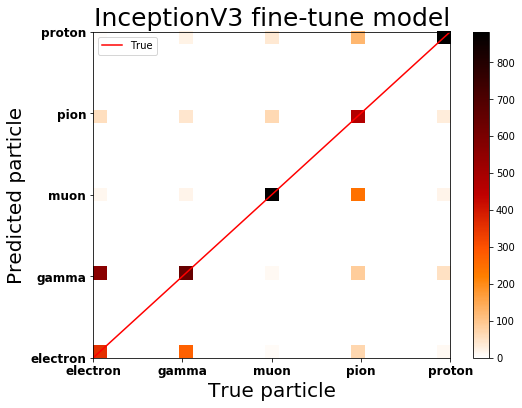

In [27]:
y_pred = InceptionV3Model.predict(X_test, verbose = False)

y_p = []
for y in y_pred:
    y_p.append(np.argmax(y))
y_t = []
for t in y_test:
    y_t.append(np.argmax(t))

fig, ax1 = plt.subplots(1,1, figsize = (8,6))
counts, xedges, yedges, im = ax1.hist2d(y_t, y_p, bins=(25, 25), cmap='gist_heat_r')
plt.colorbar(im, ax=ax1)
ax1.plot(y_t, y_t, 'r-', label = 'True')
plt.xticks(location, labels)
plt.yticks(location, labels)

ax1.legend()
ax1.set_title('InceptionV3 fine-tune model', fontsize=25)
ax1.set_xlabel('True particle', fontsize=20)
ax1.set_ylabel('Predicted particle', fontsize=20)
pt.setTicks(ax1)

fig.savefig('Plots/ClassificationInceptionV3FineTunedResult.pdf', bbox_inches='tight')

# Semantic Segmentation

### Load the training and test datasets

In [28]:
train_image_chain = ROOT.TChain("image2d_data_tree")
train_image_chain.AddFile('InputFiles/segmentation_train.root')
print 'Found', train_image_chain.GetEntries(), 'images in training dataset!'

test_image_chain = ROOT.TChain("image2d_data_tree")
test_image_chain.AddFile('InputFiles/segmentation_test.root')
print 'Found', test_image_chain.GetEntries(), 'images in test dataset!'

train_label_chain = ROOT.TChain("image2d_segment_tree")
train_label_chain.AddFile('InputFiles/segmentation_train.root')
print 'Found', train_label_chain.GetEntries(), 'labels in training dataset!'

test_label_chain = ROOT.TChain("image2d_segment_tree")
test_label_chain.AddFile('InputFiles/segmentation_test.root')
print 'Found', test_label_chain.GetEntries(), 'labels in test dataset!'

Found 2000 images in training dataset!
Found 2000 images in test dataset!
Found 2000 labels in training dataset!
Found 2000 labels in test dataset!


### Visualize a single training image: Background + Shower + Track

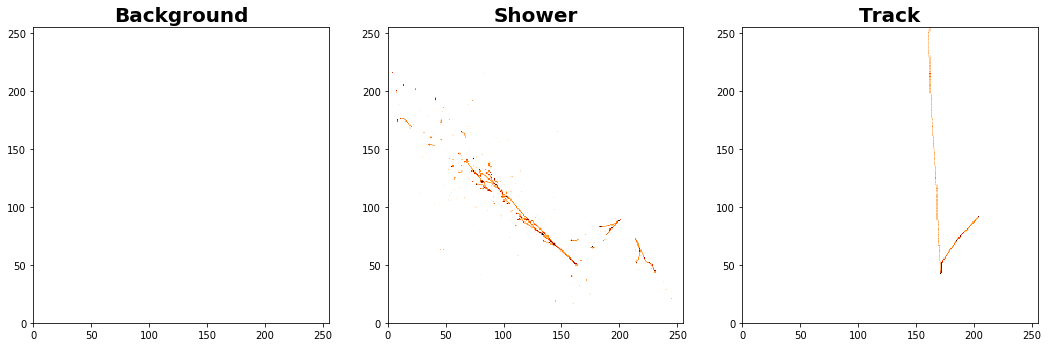

In [29]:
entry = 552
train_image_chain.GetEntry(entry)
train_label_chain.GetEntry(entry)

# Let's grab a specific projection (1st one)
image2d = larcv.as_ndarray(train_image_chain.image2d_data_branch.as_vector().front())
label2d = larcv.as_ndarray(train_label_chain.image2d_segment_branch.as_vector().front())

categories = ['Background','Shower','Track']
unique_values, unique_counts = np.unique(label2d, return_counts=True)

fig, axes = plt.subplots(1, len(unique_values), figsize=(18,12), facecolor='w')
xlim,ylim = get_view_range(image2d)
for index, value in enumerate(unique_values):
    ax = axes[index]
    mask = (label2d == value)
    ax.imshow(image2d * mask, interpolation='none', cmap='gist_heat_r', origin='lower')
    ax.set_title(categories[index],fontsize=20,fontname='DejaVu Sans',fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.show()
fig.savefig('Plots/SegmentationTrainingImageSeparated.pdf', bbox_inches='tight')

### Visualize a single training image and label in detail

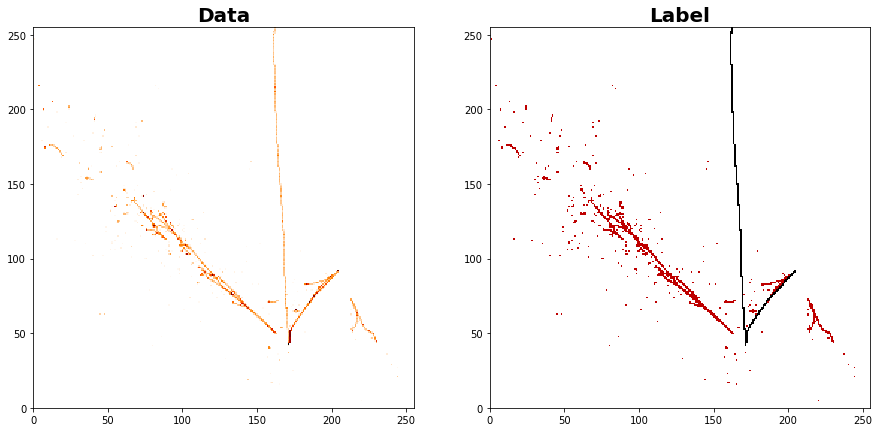

In [30]:
# Dump images
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(15,10), facecolor='w')
ax0.imshow(image2d, interpolation='none', cmap='gist_heat_r', origin='lower')
ax1.imshow(label2d, interpolation='none', cmap='gist_heat_r', origin='lower',vmin=0., vmax=2.0)
ax0.set_title('Data',fontsize=20,fontname='DejaVu Sans',fontweight='bold')
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax1.set_title('Label',fontsize=20,fontname='DejaVu Sans',fontweight='bold')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
plt.show()
fig.savefig('Plots/SegmentationTrainingImageAndLabel.pdf', bbox_inches='tight')